In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import preprocess_captions
import os.path
from data import *

if not os.path.exists("./data/captions.json"):
    preprocess_captions()

batch_size = 32
train_loader = get_loader("TRAIN", batch_size)

In [3]:
print("Vocab size:", len(train_loader.dataset.vocab))

Vocab size: 1842


Text(0.5, 0, 'Caption length')

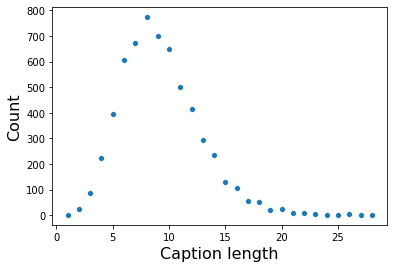

In [4]:
#
# Caption lengths distribution
#

lengths = {k: len(v) for k, v in train_loader.dataset.caption_lengths.items()}

ax = sns.scatterplot(list(lengths.keys()), list(lengths.values()))
plt.ylabel('Count', fontsize=16)
plt.xlabel('Caption length', fontsize=16)

In [5]:
# TODO: figure out the images with 0 an 1-length caption

print("Max length", max(lengths))
print("Min length", min(lengths))

Max length 28
Min length 1


In [6]:
#
# Same-length indices sampler test
#

import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = train_loader.dataset.get_indices()
print('Sampled indices: {}'.format(len(indices)))
print('Indices: {}'.format(indices))
# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(indices=indices)
train_loader.batch_sampler.sampler = sampler

# Obtain  batch
iter_loader = iter(train_loader)
images, captions = next(iter_loader)
    
print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

Sampled indices: 32
Indices: [2310, 3336, 4509, 4332, 59, 5211, 2896, 939, 3712, 5175, 3062, 2076, 434, 692, 5622, 2519, 4094, 21, 4545, 2913, 483, 2793, 4793, 1931, 3309, 5816, 4470, 5945, 194, 4054, 2503, 830]
images.shape: torch.Size([32, 3, 224, 224])
captions.shape: torch.Size([32, 8])


In [7]:
#
# Encoder and Decoder forward pass test
#

from models import Encoder, Decoder

embed_size = 256
encoder = Encoder(embed_size)

hidden_size = 512
vocab_size = len(train_loader.dataset.vocab)
decoder = Decoder(embed_size, hidden_size, vocab_size)

if batch_size == 1:
    encoder.eval() # Don't use batch norm when I'm testing with batch size=1

if torch.cuda.is_available():
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    images = images.cuda()
    captions = captions.cuda()
    
features = encoder(images)
outputs = decoder(features, captions)

# Features shape should be (batch_size, embed_size)
print(features.shape)

# Outputs shape should be (batch_size, captions.shape[1], vocab_size)
print(outputs.shape)

torch.Size([32, 256])
torch.Size([32, 8, 1842])


In [8]:
#
# Encoder and Decoder backward pass test
#
import torch
from torch import nn

criterion = nn.CrossEntropyLoss().cuda()
params = (list(filter(lambda p: p.requires_grad, encoder.parameters()))+
        list(filter(lambda p: p.requires_grad, decoder.parameters())))
optimizer = torch.optim.Adam(params, lr=0.001)

loss = criterion(outputs.view(-1, len(train_loader.dataset.vocab)), captions.view(-1))
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [9]:
#
# Validation loader test
#

from train_utils import bleu_eval, early_stopping

embed_size = 256
encoder = Encoder(embed_size)

hidden_size = 512
vocab_size = len(train_loader.dataset.vocab)
decoder = Decoder(embed_size, hidden_size, vocab_size)

encoder.eval()
decoder.eval()

val_loader = get_loader("VAL", 2)

# Randomly sample a caption length, and sample indices with that length.
indices = val_loader.dataset.get_indices()
# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(indices=indices)
val_loader.batch_sampler.sampler = sampler

# Obtain batch
iter_loader = iter(val_loader)
images, captions, all_caps = next(iter_loader)

if torch.cuda.is_available():
    encoder = encoder.cuda()
    decoder = decoder.cuda()
    images = images.cuda()
    captions = captions.cuda()
    
features = encoder(images)
outputs = decoder(features, captions)

# features shape should be (batch_size, embed_size)
print(features.shape)

# outputs shape should be (batch_size, captions.shape[1], vocab_size)
print(outputs.shape)

# all_caps shape should be (batch_size, #caption per image, max_caption_length)
print(all_caps.shape)

torch.Size([2, 256])
torch.Size([2, 16, 1842])
torch.Size([2, 5, 50])


In [10]:
#
# Batched BLEU scoring test
#

_, predicted = outputs.max(2)
candidates = predicted.to("cpu").numpy()
batch_bleu_score = bleu_eval(candidates, all_caps, val_loader.dataset.vocab)
batch_bleu_score

0

In [11]:
#
# Early stopping test
#

a = [1, 1, 1, 5, 1, 1, 1]
print(early_stopping(a))
a = [1, 1, 1, 5, 6, 1, 1]
print(early_stopping(a))
a = [1, 1, 1, 5, 5, 5, 5]
print(early_stopping(a))
a = [1, 2, 3, 4, 5, 6, 7]
print(early_stopping(a))

True
False
True
False


In [12]:
#
# Saving checkpoint test
#
import os
epoch = 1
i = 1
filename = os.path.join("./data/models/checkpoints/tmp-model-{}-{}.ckpt".format(epoch, i))
print(filename)
torch.save({"encoder": encoder.state_dict(),
            "decoder": decoder.state_dict(),
            "optimizer" : optimizer.state_dict(),
            "total_loss": 0,
            "epoch": epoch,
            "train_step": i,
        }, filename)

./data/models/checkpoints/tmp-model-1-1.ckpt
